### Introduction to Decision Trees and Forests

**OBJECTIVES**

- Understand how a decision tree is built for classification and regression
- Fit decision tree models using `scikit-learn`
- Control overfitting by grid searching and cross validating
- Understand the random forest model and fit models using `scikit-learn`
- Examine feature importance of fit tree and forest models

In [39]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import OneHotEncoder

#### Titanic Dataset

In [40]:
#load the data
titanic = sns.load_dataset('titanic')
titanic.head(5) #shows first five rows of data

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [41]:
#subset the data to binary columns
data = titanic.loc[:4, ['alone', 'adult_male', 'survived']]
data

,alone,adult_male,survived
0,False,True,0
1,False,False,1
2,True,False,1
3,False,False,1
4,True,True,0


Suppose you want to use a single column to predict if a passenger survives or not.  Which column will do a better job predicting survival in the sample dataset above?

In [42]:
#survival by alone
data.groupby('alone')['survived'].value_counts()

alone  survived
False  1           2
       0           1
True   0           1
       1           1
Name: survived, dtype: int64

In [43]:
#survival by adult_male
data.groupby('adult_male')['survived'].value_counts()

adult_male  survived
False       1           3
True        0           2
Name: survived, dtype: int64

### Entropy

One way to quantify the quality of the split is to use a quantity called **entropy**.  This is determined by:

$$H = - \sum p_i \log p_i $$

With a decision tree the idea is to select a feature that produces less entropy.  

In [44]:
#all the same -- probability = 1
1*np.log2(1)

0.0

In [45]:
#half and half -- probability = .5
-(1/2*np.log2(1/2) + 1/2*np.log2(1/2))

1.0

In [46]:
#subset the data to age, pclass, and survived five rows
data = titanic.loc[:4, ['age', 'pclass', 'survived']]
data

,age,pclass,survived
0,22.0,3,0
1,38.0,1,1
2,26.0,3,1
3,35.0,1,1
4,35.0,3,0


In [47]:
#compute entropy for pclass
#first class entropy
first_class_entropy = -(2/2*np.log2(2/2))
first_class_entropy

-0.0

In [48]:
#pclass entropy
third_class_entropy = -(1/3*np.log2(1/3) + 2/3*np.log2(2/3))
third_class_entropy

0.9182958340544896

In [54]:
#weighted sum of these
pclass_entropy = 2/5*first_class_entropy + 3/5*third_class_entropy

In [50]:
#splitting on age < 30
entropy_left = -(1/2*np.log2(1/2) + 1/2*np.log2(1/2))
entropy_right = -(1/3*np.log2(1/3) + 2/3*np.log2(2/3))
entropy_age = 2/5*entropy_left + 3/5*entropy_right
entropy_age

0.9509775004326937

In [53]:
#original entropy
original_entropy = -((3/5)*np.log2(3/5) + (2/5)*np.log2(2/5))
original_entropy 

0.9709505944546686

In [55]:
# improvement based on pclass
original_entropy - pclass_entropy

0.4199730940219749

In [56]:
#improvement based on age < 30
original_entropy - entropy_age

0.01997309402197489

**EXAMPLE**

#### Using `sklearn`

The `DecisionTreeClassifier` can use `entropy` to build a full decision tree model.  Below we build and visualize such a model.

In [57]:
X = data[['age', 'pclass']]
y = data['survived']

In [58]:
from sklearn.tree import DecisionTreeClassifier

In [60]:
#DecisionTreeClassifier?

In [61]:
#instantiate
tree = DecisionTreeClassifier(criterion='entropy', max_depth = 1)

In [62]:
#fit
tree.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=1)

In [63]:
#score it
tree.score(X, y)

0.8

In [64]:
#predictions
tree.predict(X)

array([0, 1, 0, 1, 0])

#### Visualizing the results

The `plot_tree` function will plot the decision tree model after fitting.  There are many options you can use to control the resulting tree drawn.

In [65]:
from sklearn.tree import plot_tree

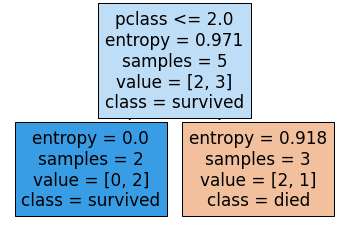

In [70]:
#plot_tree
plot_tree(tree, feature_names=X.columns, class_names=['died', 'survived'], filled = True);

**Larger Example**

In [71]:
bigger_data = titanic[['pclass', 'age', 'fare', 'survived']].dropna()
bigger_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    714 non-null    int64  
 1   age       714 non-null    float64
 2   fare      714 non-null    float64
 3   survived  714 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 27.9 KB


In [72]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [73]:
X = bigger_data.drop('survived', axis = 1)
y = bigger_data['survived']

In [74]:
#instantiate
bigger_tree = DecisionTreeClassifier(criterion = 'entropy')
#fit
bigger_tree.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

In [75]:
#evaluate -- Accuracy aka percent correct
bigger_tree.score(X, y)

0.9705882352941176

In [76]:
1 - bigger_tree.score(X, y) #error rate

0.02941176470588236

In [79]:
X.columns.tolist()

['pclass', 'age', 'fare']

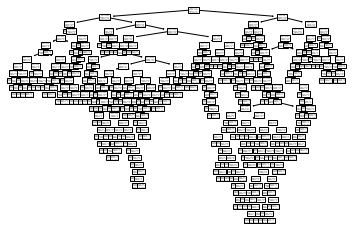

In [77]:
plot_tree(bigger_tree, feature_names = X.columns.tolist());

Looks like this may overfit the data and not generalize well!  It is important to continue to use what we discussed in terms of train/test split and cross validation to explore the quality of the model fit.  

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)

In [81]:
bigger_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [82]:
bigger_tree.score(X_train, y_train)

0.9775700934579439

In [83]:
bigger_tree.score(X_test, y_test)

0.664804469273743

#### Control `max_depth`

There are many hyperparameters in the decision tree model.  One thing we may seek to control is how many decisions are allowed to be made.  This is determined by the `max_depth` parameter, essentially stopping the decision tree after a set number of splits.

In [84]:
#decision tree with depth of 3
constrained_tree = DecisionTreeClassifier(criterion = 'entropy',
                                          max_depth = 3)

In [85]:
#fit on train
constrained_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [86]:
#score on train
constrained_tree.score(X_train, y_train)

0.7177570093457943

In [87]:
#score on test
constrained_tree.score(X_test, y_test)

0.6815642458100558

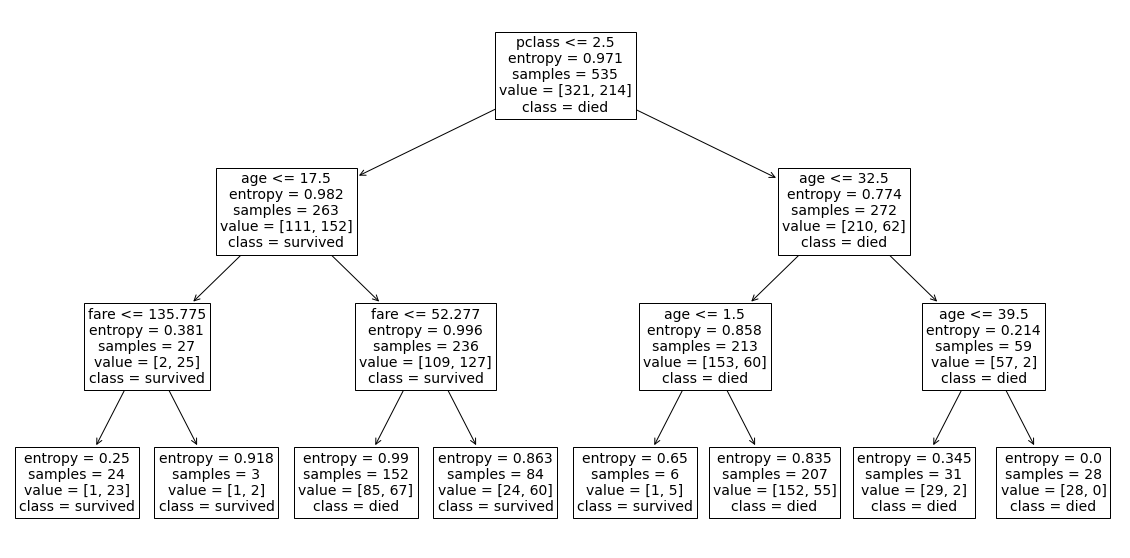

In [90]:
#plot results
fig, ax = plt.subplots(figsize = (20, 10))
plot_tree(constrained_tree, feature_names=X.columns, ax = ax, fontsize = 14, class_names = [ 'died', 'survived']);

### Selecting the Best Tree

In [91]:
train_scores = []
test_scores = []
for d in range(1, 20):
    dtree = DecisionTreeClassifier(criterion = 'entropy',
                                 max_depth = d).fit(X_train, y_train)
    train_scores.append(dtree.score(X_train, y_train))
    test_scores.append(dtree.score(X_test, y_test))

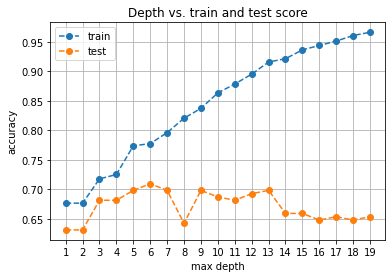

In [92]:
plt.plot(range(1, 20), train_scores, '--o', label = 'train')
plt.plot(range(1, 20), test_scores, '--o', label = 'test')
plt.grid()
plt.legend()
plt.xticks(range(1, 20))
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('Depth vs. train and test score');

In [93]:
dtree = DecisionTreeClassifier(criterion = 'entropy',
                               max_depth = 6).fit(X_train, y_train)

In [94]:
dtree.score(X_train, y_train)

0.7775700934579439

In [95]:
dtree.score(X_test, y_test)

0.7039106145251397

#### Evaluating Importance

By tracking how frequently a feature was used to make a split, we can determine the "importance" of each feature.  These are stored in the `feature_importances_` attribute of the fit model.  

In [96]:
#feature importances
dtree.feature_importances_

array([0.31017874, 0.47198358, 0.21783768])

In [97]:
#features
dtree.feature_names_in_

array(['pclass', 'age', 'fare'], dtype=object)

In [98]:
pd.DataFrame({'features': dtree.feature_names_in_, 'importance': dtree.feature_importances_})

,features,importance
0,pclass,0.310179
1,age,0.471984
2,fare,0.217838


#### Problem

Use a decision tree model to predict heart conditions using the data below.  

In [99]:
heart = pd.read_csv('https://raw.githubusercontent.com/jfkoehler/nyu_bootcamp_fa23/main/data/heart_cleveland_upload.csv')

In [100]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


In [101]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [113]:
X = heart.iloc[:, :-1]
y = heart['condition']

In [132]:
dtree = DecisionTreeClassifier(random_state=22)

In [133]:
tree_params = {'max_depth': [2, 3, 4, 5, 6, 20]}

In [134]:
tree_grid = GridSearchCV(dtree, param_grid=tree_params)

In [135]:
tree_grid.fit(X, y)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=22),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 20]})

In [136]:
tree_grid.score(X, y)

0.8552188552188552

In [137]:
tree_grid.best_params_

{'max_depth': 3}

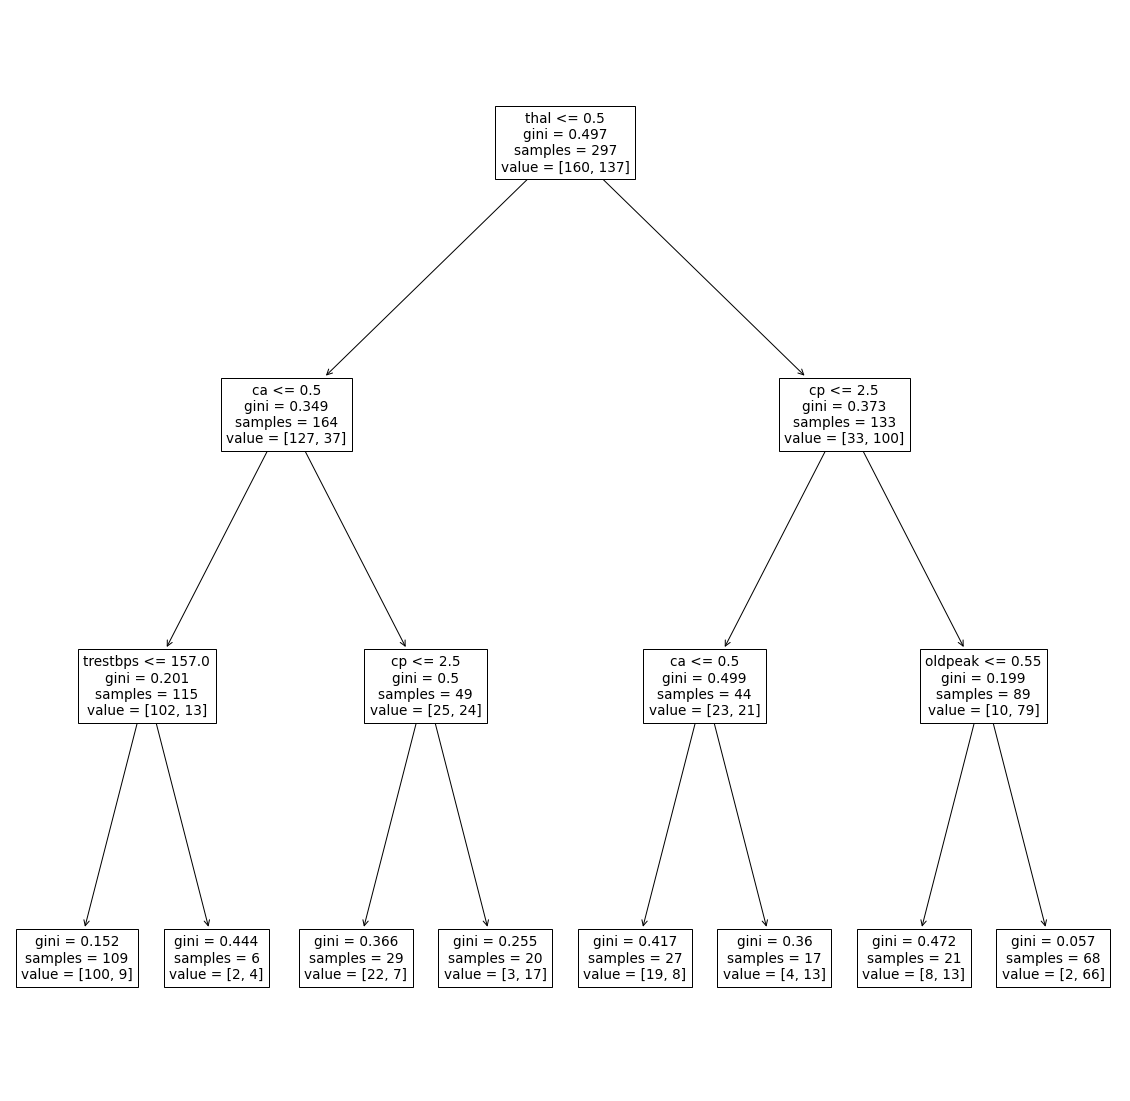

In [111]:
fig, ax = plt.subplots(figsize = (20, 20))
plot_tree(tree_grid.best_estimator_, feature_names=X.columns, ax = ax);